# AML Fraud Detection - ETL and ML Model
The notebook loads the CSV data from the CSO. Data cleansing and ETL Pipeline is created. Data is then split into train and test
This is a binary classification problem to detect whether a transaction is fraud or not.
First SVM algorithm is applied and then GBT is applied. Further Cross validator is used for improving the accuracy

Data Ingestion from IBM CSO

In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_9ad76f82714e48d7811b2543f2936693 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='LULdO8iN1GZFvjpg50QiRnWJ5P8eKsQXFxJaHODlPJWJ',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_9ad76f82714e48d7811b2543f2936693.get_object(Bucket='dsx-donotdelete-pr-tjck77hosph311',Key='subset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data_1 = df_data[0 : 31057]
df_data_1.tail()



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
31052,95.0,TRANSFER,56745.14,C872526349,56745.14,0.0,C1824885183,0.00,0.00,1.0,0.0
31053,95.0,CASH_OUT,56745.14,C526144262,56745.14,0.0,C79051264,51433.88,108179.02,1.0,0.0
31054,95.0,TRANSFER,33676.59,C732111322,33676.59,0.0,C1140210295,0.00,0.00,1.0,0.0
31055,95.0,CASH_OUT,33676.59,C1000086512,33676.59,0.0,C1759363094,0.00,33676.59,1.0,0.0
31056,95.0,TRANSFER,87999.25,C927181710,87999.25,0.0,C757947873,0.00,0.00,1.0,0.0


In [3]:
df_data_2 = spark.createDataFrame(df_data_1)

In [4]:

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

ETL Pipeline

In [5]:
stringIndexer = StringIndexer(inputCol="type", outputCol="typeVectors")
encoder = OneHotEncoder(inputCol='typeVectors', outputCol='typeVectors_enc')
vectorAssembler = VectorAssembler(inputCols=['amount', 'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], outputCol='features')
normalizer = Normalizer(inputCol = 'features', outputCol = 'features_norm', p=1.0)

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC

pipeline = Pipeline(stages=[stringIndexer, encoder,vectorAssembler,normalizer])

Fitting the data on the pipeline

In [7]:
model = pipeline.fit(df_data_2).transform(df_data_2)

In [8]:
model.collect()

[Row(step=1.0, type='PAYMENT', amount=9839.64, nameOrig='C1231006815', oldbalanceOrg=170136.0, newbalanceOrig=160296.36, nameDest='M1979787155', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0.0, isFlaggedFraud=0.0, typeVectors=0.0, typeVectors_enc=SparseVector(4, {0: 1.0}), features=DenseVector([9839.64, 170136.0, 160296.36, 0.0, 0.0]), features_norm=DenseVector([0.0289, 0.5, 0.4711, 0.0, 0.0])),
 Row(step=1.0, type='PAYMENT', amount=1864.28, nameOrig='C1666544295', oldbalanceOrg=21249.0, newbalanceOrig=19384.72, nameDest='M2044282225', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0.0, isFlaggedFraud=0.0, typeVectors=0.0, typeVectors_enc=SparseVector(4, {0: 1.0}), features=DenseVector([1864.28, 21249.0, 19384.72, 0.0, 0.0]), features_norm=DenseVector([0.0439, 0.5, 0.4561, 0.0, 0.0])),
 Row(step=1.0, type='PAYMENT', amount=11668.14, nameOrig='C2048537720', oldbalanceOrg=41554.0, newbalanceOrig=29885.86, nameDest='M1230701703', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0.0, i

In [9]:
model.createOrReplaceTempView('df_model_data')
df_model_data = spark.sql('select features_norm,isFraud from df_model_data')
df_model_data.schema.fieldNames = ['features_norm','labels']
df_model_data = df_model_data.withColumnRenamed('isFraud','label')
df_model_data = df_model_data.withColumnRenamed('features_norm','features')
df_model_data.take(5)



[Row(features=DenseVector([0.0289, 0.5, 0.4711, 0.0, 0.0]), label=0.0),
 Row(features=DenseVector([0.0439, 0.5, 0.4561, 0.0, 0.0]), label=0.0),
 Row(features=DenseVector([0.1404, 0.5, 0.3596, 0.0, 0.0]), label=0.0),
 Row(features=DenseVector([0.0726, 0.5, 0.4274, 0.0, 0.0]), label=0.0),
 Row(features=DenseVector([0.0194, 0.5, 0.4806, 0.0, 0.0]), label=0.0)]

Data split for training and test

In [10]:
train_X, test_y = df_model_data.randomSplit([0.8, 0.2], seed=443)
train_X.count(), test_y.count()
train_X

DataFrame[features: vector, label: double]

---------------------------------------------------------------------------------------------

# #*******************Support Vector Machine based model*************************

________________________________________________________________

Fitting the data on the SVM model

In [11]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter= 15, regParam=0.2)
lsvc_model = lsvc.fit((train_X))
lsvc_pred = lsvc_model.transform(train_X)

In [12]:
print(lsvc_model.coefficients)
print(lsvc_model.intercept)

[-0.680519912832,-0.580215732712,-0.681561471107,-0.628257919461,-0.635137003897]
-0.3709889841899958


In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
lsvc_eval = BinaryClassificationEvaluator().setLabelCol('label').setRawPredictionCol("prediction")


Accuracy evaluation and prediction

In [14]:
lsvc_eval.evaluate(lsvc_pred)

0.5

In [15]:
lsvc_pred_y = lsvc_model.transform(test_y)
lsvc_eval.evaluate(lsvc_pred_y)

0.5

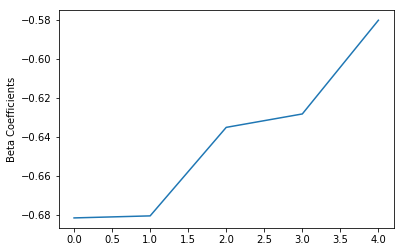

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lsvc_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

---------------------------------------------------------------
******************Gradient Boosted Tree ***********************
------------------------------------------------------------------

Because SVC accuracy less, GBTClassifier is being tried

In [17]:
from pyspark.ml.classification import GBTClassifier


gbtc = GBTClassifier(labelCol = 'label', featuresCol='features', maxIter= 15)
gbtc_model = gbtc.fit((train_X))
gbtc_pred = gbtc_model.transform(train_X)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
gbtc_eval = BinaryClassificationEvaluator().setLabelCol('label').setRawPredictionCol("prediction")

gbtc_eval.evaluate(gbtc_pred)


0.7347285067873304

In [18]:

gbtc_pred_y = gbtc_model.transform(test_y)
gbtc_eval.evaluate(gbtc_pred_y)

0.7354085603112841


-------------------------------------------------
##****Cross Validator for improving accuracy****
-------------------------------------------------

Using CrossValidator for improving the accuracy of the GBTClassifier

In [19]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator

paramGrid = ParamGridBuilder().addGrid(gbtc.maxBins, [2,4,8, 16]).addGrid(gbtc.maxDepth, [2,4,6,16]).build()



In [20]:
crossVal = CrossValidator(estimator=gbtc,
                         estimatorParamMaps=paramGrid,
                         evaluator=BinaryClassificationEvaluator(),
                         numFolds=4)

In [21]:
cvmodel = crossVal.fit(train_X)

In [22]:
cvmodel_predict = cvmodel.transform(train_X)
cvmodel_predict

DataFrame[features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

In [23]:
cvmodel_predict_y = cvmodel.transform(test_y)

Accuracy increased to 96%

In [24]:
gbtc_eval.evaluate(cvmodel_predict)

0.9606260581171586

In [25]:
gbtc_eval.evaluate(cvmodel_predict_y)

0.9629600025682638